In [106]:
import numpy as np
import pandas as pd
import seaborn as sns

#from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.preprocessing import MinMaxScaler
from sklearn.dummy import DummyClassifier
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay
from sklearn.metrics import classification_report, roc_auc_score, average_precision_score, f1_score
from sklearn.metrics import roc_curve, precision_recall_curve  
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.calibration import CalibrationDisplay, CalibratedClassifierCV
from sklearn.inspection import permutation_importance

## 3.5 Gradient Boosting<a id="Gradient Boosting"></a>
[Back to top](#top)

- Import preprocessed features as DataFrame and target variables as Series

In [107]:
# training and test sets with original data distribution

X_train = pd.read_csv('https://raw.githubusercontent.com/F4LLC0N3R/ML-Group-2---Diabetes/main/data/X_train.csv')
y_train = pd.read_csv('https://raw.githubusercontent.com/F4LLC0N3R/ML-Group-2---Diabetes/main/data/y_train.csv', squeeze=True)

X_test = pd.read_csv('https://raw.githubusercontent.com/F4LLC0N3R/ML-Group-2---Diabetes/main/data/X_test.csv')
y_test = pd.read_csv('https://raw.githubusercontent.com/F4LLC0N3R/ML-Group-2---Diabetes/main/data/y_test.csv', squeeze=True)

In [108]:
# resampled / balanced training sets

X_train_rus = pd.read_csv('https://raw.githubusercontent.com/F4LLC0N3R/ML-Group-2---Diabetes/main/data/X_train_rus.csv')
y_train_rus = pd.read_csv('https://raw.githubusercontent.com/F4LLC0N3R/ML-Group-2---Diabetes/main/data/y_train_rus.csv', squeeze=True)

X_train_ros = pd.read_csv('https://raw.githubusercontent.com/F4LLC0N3R/ML-Group-2---Diabetes/main/data/X_train_ros.csv')
y_train_ros = pd.read_csv('https://raw.githubusercontent.com/F4LLC0N3R/ML-Group-2---Diabetes/main/data/y_train_ros.csv', squeeze=True)

X_train_smote = pd.read_csv('https://raw.githubusercontent.com/F4LLC0N3R/ML-Group-2---Diabetes/main/data/X_train_smote.csv')
y_train_smote = pd.read_csv('https://raw.githubusercontent.com/F4LLC0N3R/ML-Group-2---Diabetes/main/data/y_train_smote.csv', squeeze=True)

### 3.5.1 Initial Model Building and Evaluation
[Back to top](#top)

#### Model Building
- Training a base model with default values to check our starting point.

In [163]:
clf = %time GradientBoostingClassifier(random_state=42).fit(X_train, y_train.values)

clf.score(X_test, y_test)

Wall time: 18.7 s


0.9125279642058165

- The base model almost has identical first results compared to the previous models. 

#### Model Evaluation

In [153]:
# Predict labels
y_pred = clf.predict(X_test)

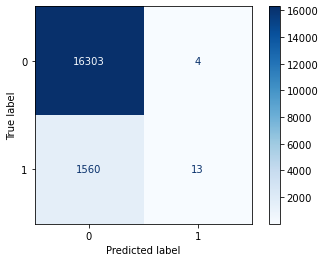

In [151]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='Blues')

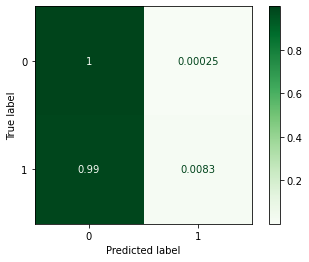

In [152]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='Greens', normalize='true')

In [154]:
# Print evaluation metrics
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      1.00      0.95     16307
           1       0.76      0.01      0.02      1573

    accuracy                           0.91     17880
   macro avg       0.84      0.50      0.49     17880
weighted avg       0.90      0.91      0.87     17880



Just like the other models, the accuracy score of the Gradient Boosted model is high, as more than 90% of the target values are the same (0). On the other hand, the Precision of the Gradient Boosted model is slightly better, with 75%. However, the F1-score and Recall score are once again lacking.

### 3.5.2 Hyperparameter Tuning
[Back to top](#top)

In [112]:
# Show hyperparameters and their values
clf.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'deviance',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'random_state': 42,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [113]:
clf.get_params().keys()

dict_keys(['ccp_alpha', 'criterion', 'init', 'learning_rate', 'loss', 'max_depth', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_iter_no_change', 'random_state', 'subsample', 'tol', 'validation_fraction', 'verbose', 'warm_start'])

Hyperparameters to be varied:  
- `criterion`: The default value is "friedman_mse", yet we also test "squared_error" to evaluate which one is better at measuring the quality of the split.
- `learning_rate` & `n_estimators`: "learning_rate" and "n_estimators" have a trade-off between each other. Both of these parameters are tuned to find the best synergy. 
- `max_depth`: To find the optimal limit to the number of nodes in the tree that is created.
- `min_weight_fraction_leaf`: To adjust the sample_weight when splitting the tree. 
- `max_features`: The number of features that will be considered for splitting the tree.
- `min_samples_split`: The least amound of samples that must be reached before splitting the tree. 

Just as before, we attempt to imptove the accuracy of the model to begin with. This is done by first conducting a Randomized Search to find the main hyperparameter ranges that we can work with. Once we know the approximate optimal range for the hyperparameters, we use GridSearchCV to further finetune some of the hyperparameters. 

In [114]:
param_grid = {'criterion': ['friedman_mse','squared_error'],
              'learning_rate': np.linspace(0.1, 1, 10),
              'max_depth': np.linspace(1, 300, 15, dtype='int'),
              'min_weight_fraction_leaf': [0.1,0.2,0.5,0.0],
              'max_features': ['auto','sqrt','log2'],
              'min_samples_split': [2, 10, 50],
              'n_estimators': [5, 10, 50, 100, 300],        
             }

In [115]:
random_search = RandomizedSearchCV(estimator=clf, 
                                   param_distributions = param_grid,
                                   n_jobs=-1,
                                   cv=3, #reduced to 3-fold to reduce runtime
                                   verbose=1)
%time random_search.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Wall time: 49.5 s


RandomizedSearchCV(cv=3, estimator=GradientBoostingClassifier(random_state=42),
                   n_jobs=-1,
                   param_distributions={'criterion': ['friedman_mse',
                                                      'squared_error'],
                                        'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
                                        'max_depth': array([  1,  22,  43,  65,  86, 107, 129, 150, 171, 193, 214, 235, 257,
       278, 300]),
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_split': [2, 10, 50],
                                        'min_weight_fraction_leaf': [0.1, 0.2,
                                                                     0.5, 0.0],
                                        'n_estimators': [5, 10, 50, 100, 300]},
                   verbose=1)

- Having a look at the results of the estimators that were tried

In [116]:
rs_cv_results = pd.DataFrame(random_search.cv_results_)
rs_cv_results.sort_values(by='mean_test_score', ascending=False)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_min_weight_fraction_leaf,param_min_samples_split,param_max_features,param_max_depth,param_learning_rate,param_criterion,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
1,0.486442,0.020142,0.079688,0.011325,10,0.1,10,sqrt,193,0.5,squared_error,"{'n_estimators': 10, 'min_weight_fraction_leaf...",0.911969,0.912020,0.912020,0.912003,0.000024,1
2,0.349412,0.043155,0.055679,0.005438,5,0.1,10,sqrt,107,0.6,friedman_mse,"{'n_estimators': 5, 'min_weight_fraction_leaf'...",0.911969,0.912020,0.912020,0.912003,0.000024,1
3,0.366414,0.034009,0.064016,0.004900,10,0.1,10,sqrt,86,0.3,friedman_mse,"{'n_estimators': 10, 'min_weight_fraction_leaf...",0.911969,0.912020,0.912020,0.912003,0.000024,1
4,5.363536,0.282607,0.261057,0.021281,300,0.1,10,sqrt,22,0.2,friedman_mse,"{'n_estimators': 300, 'min_weight_fraction_lea...",0.911969,0.912020,0.912020,0.912003,0.000024,1
6,2.742948,0.073121,0.164371,0.011441,300,0.1,10,log2,107,0.7,squared_error,"{'n_estimators': 300, 'min_weight_fraction_lea...",0.911969,0.912020,0.912020,0.912003,0.000024,1
7,0.223384,0.007589,0.045011,0.002162,10,0.2,10,sqrt,300,0.5,squared_error,"{'n_estimators': 10, 'min_weight_fraction_leaf...",0.911969,0.912020,0.912020,0.912003,0.000024,1
5,0.215379,0.017252,0.041342,0.001699,10,0,50,sqrt,1,0.7,squared_error,"{'n_estimators': 10, 'min_weight_fraction_leaf...",0.911745,0.912020,0.911796,0.911854,0.000119,7
0,35.791024,0.201265,0.263704,0.012685,50,0,10,log2,65,0.2,friedman_mse,"{'n_estimators': 50, 'min_weight_fraction_leaf...",0.911521,0.911460,0.911572,0.911518,0.000046,8
9,39.834946,0.535893,0.306400,0.009979,300,0,10,log2,43,0.5,friedman_mse,"{'n_estimators': 300, 'min_weight_fraction_lea...",0.911353,0.911293,0.911684,0.911443,0.000172,9
8,3.910873,0.052933,0.060680,0.003860,5,0,10,log2,235,0.4,squared_error,"{'n_estimators': 5, 'min_weight_fraction_leaf'...",0.888535,0.888249,0.889479,0.888754,0.000526,10


In [117]:
random_search.best_params_

{'n_estimators': 10,
 'min_weight_fraction_leaf': 0.1,
 'min_samples_split': 10,
 'max_features': 'sqrt',
 'max_depth': 193,
 'learning_rate': 0.5,
 'criterion': 'squared_error'}

In [122]:
clf_opt = random_search.best_estimator_

In [123]:
random_search.best_estimator_.score(X_test, y_test)

0.9120246085011185

- After getting an idea of the optimal hyperparameters, they are tuned slightly more with a GridSearchCV, which is more thorough.

In [168]:
gridsearch_param_grid = {'learning_rate': [0.4, 0.5, 0.6],
              'max_depth': [220, 230, 235],
              'min_weight_fraction_leaf': [0.2, 0.3, 0.4],
              'min_samples_split': [20, 35, 40],
              'n_estimators': [10, 13, 20],        
            }

In [169]:
# initialize grid search with roc-auc as score
gridsearch_roc = GridSearchCV(clf, param_grid = gridsearch_param_grid, scoring='roc_auc', cv=3, n_jobs=-1, verbose=1)

# fit on training data
%time gridsearch_roc.fit(X_train, y_train)

Fitting 3 folds for each of 243 candidates, totalling 729 fits
Wall time: 2min 35s


GridSearchCV(cv=3, estimator=GradientBoostingClassifier(random_state=42),
             n_jobs=-1,
             param_grid={'learning_rate': [0.4, 0.5, 0.6],
                         'max_depth': [220, 230, 235],
                         'min_samples_split': [20, 35, 40],
                         'min_weight_fraction_leaf': [0.2, 0.3, 0.4],
                         'n_estimators': [10, 13, 20]},
             scoring='roc_auc', verbose=1)

In [170]:
clf_opt_gridsearch = gridsearch_roc.best_estimator_

In [171]:
gridsearch_roc.best_params_

{'learning_rate': 0.4,
 'max_depth': 220,
 'min_samples_split': 20,
 'min_weight_fraction_leaf': 0.2,
 'n_estimators': 20}

In [172]:
gridsearch_roc.best_estimator_.score(X_test, y_test)

0.9120246085011185

- The hyperparameter tuning has not rendered significant improvements. 

#### 'Optimized' Model Evaluation
The hyperparameter tuning has not rendered significant improvements. 

In [124]:
# Predict labels
y_pred = clf_opt.predict(X_test)

# Print metrics
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      1.00      0.95     16307
           1       0.00      0.00      0.00      1573

    accuracy                           0.91     17880
   macro avg       0.46      0.50      0.48     17880
weighted avg       0.83      0.91      0.87     17880



C:\Users\dnils\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\dnils\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\dnils\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


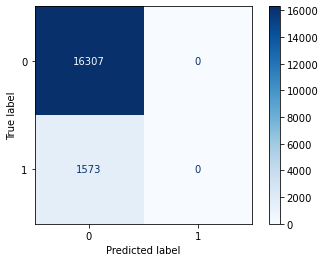

In [125]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='Blues')

Even this model predicts everything as 0.

In [173]:
# Predict labels
y_pred = clf_opt_gridsearch.predict(X_test)

# Print metrics
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      1.00      0.95     16307
           1       0.00      0.00      0.00      1573

    accuracy                           0.91     17880
   macro avg       0.46      0.50      0.48     17880
weighted avg       0.83      0.91      0.87     17880



C:\Users\dnils\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\dnils\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\dnils\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


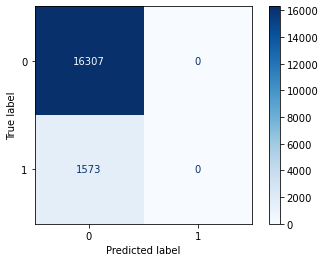

In [174]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='Blues')

### 3.5.4 Gradient Boosting ROC-AUC
[Back to top](#top)

As explained earlier, the ROC-AUC could be a better metric compared to Accuracy, as we are dealing with and imbalanced dataset and the ROC-AUC metric dictates to what extent the model can differentiate between classes.

In [126]:
# calculate prediction probabilities
y_prob = clf.predict_proba(X_test)

# calculate roc-auc
roc_auc_score(y_test, y_prob[:,1])

0.6576479291515221

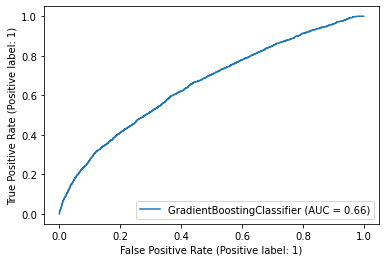

In [127]:
# plot roc curve
RocCurveDisplay.from_estimator(clf, X_test, y_test)

The ROC curve is not very different from the other models with a value of 0.66.  

While class_weight has been used in the other models for further handle imbalance, it is not relevant for this Gradient Boosted model. Instead, Gradient Boosted models handle imbalance by training iteratively, with respect to the incorrect classifications.

#### Probability Calibration



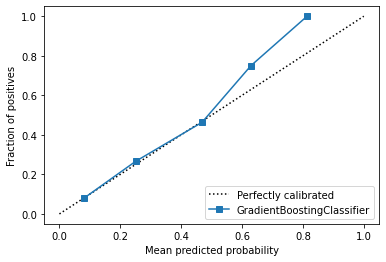

In [181]:
CalibrationDisplay.from_estimator(clf, X_test, y_test)

While the Gradient Boosting model seems to be relatively well calibrated, there is room for improvement. 

In [182]:
# fit and calibrate model on training data

clf_calibrated = CalibratedClassifierCV(clf, n_jobs=-1)
%time clf_calibrated.fit(X_train, y_train)

Wall time: 19.2 s


CalibratedClassifierCV(base_estimator=GradientBoostingClassifier(random_state=42),
                       n_jobs=-1)

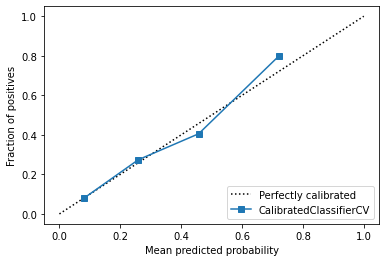

In [184]:
CalibrationDisplay.from_estimator(clf_calibrated, X_test, y_test)

#### G-Mean Optimizing Threshold Selection

After calibration, we attempt to maximize geometric mean between the True Positive Rate (TPR) and False Positive Rate (FPR). 

In [186]:
# predict probabilities
y_prob = clf_calibrated.predict_proba(X_test)

# probabilities for the positive outcome only
y_prob_1 = y_prob[:, 1]

# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob_1)

# calculate g-mean for every threshold
gmeans = np.sqrt(tpr * (1-fpr))

In [187]:
# Save in dataframe and sort by gmean

df_thresh = pd.DataFrame({'Threshold': thresholds, 'FPR': fpr, 'TPR': tpr, 'GMean': gmeans})
df_thresh.sort_values(by='GMean', ascending=False)

,Threshold,FPR,TPR,GMean
1690,0.077853,0.408659,0.634456,0.612520
1664,0.078690,0.400258,0.625556,0.612513
1628,0.079979,0.386582,0.611570,0.612493
1682,0.078024,0.406942,0.632549,0.612486
1684,0.077979,0.407862,0.633185,0.612318
...,...,...,...,...
2,0.692418,0.000000,0.002543,0.050427
3,0.646534,0.000061,0.002543,0.050426
1,0.768425,0.000000,0.000636,0.025214
0,1.768425,0.000000,0.000000,0.000000


In [188]:
# get the best threshold
best_thresh = thresholds[np.argmax(gmeans)]
best_thresh

0.07785328251740202

#### Weighed Model Evaluation

In [189]:
# calculate probability estimates for class 1
y_prob = clf_calibrated.predict_proba(X_test)
y_prob_1 = y_prob[:,1]

#calculate predictions using custom discrimination threshold
y_pred = (y_prob_1 >= best_thresh).astype(int)

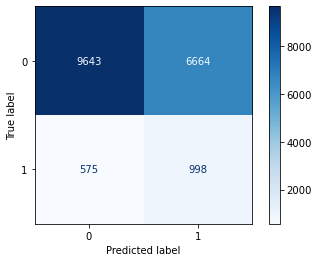

In [190]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='Blues')

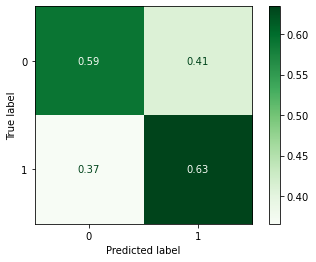

In [191]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, normalize='true', cmap='Greens')

In [192]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.59      0.73     16307
           1       0.13      0.63      0.22      1573

    accuracy                           0.60     17880
   macro avg       0.54      0.61      0.47     17880
weighted avg       0.87      0.60      0.68     17880



Once again, to get better results with the minority class, we sacrifice the performance in the majority class. Recall score for example has rised up to 63% for TPR, but TNR has been reduced to 59%. The Precision score has also declined significantly.

### 3.5.5 Precision-Recall Curve
[Back to top](#top)

As before, we look at the precision-recall curve which only takes the class 1 into account and to select the threshold according to precision and recall.

In [194]:
y_prob_1 = clf_calibrated.predict_proba(X_test)[:,1]
average_precision_score(y_test, y_prob_1)

0.1802970566701708

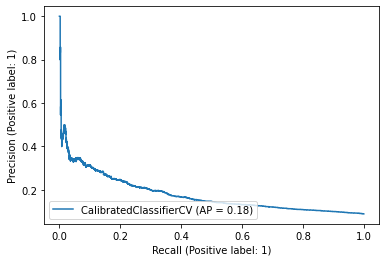

In [195]:
PrecisionRecallDisplay.from_estimator(clf_calibrated, X_test, y_test)

The Gradient Boosted model has a precision, which is represented by AUC, of 18%.

#### F-Score Optimizing Threshold Selection
We attempt to optimize the F1 score as it is a harmonic mean between precision and recall. Furthermore, we optimize the F2 score, where recall is more important than precision.

In [196]:
# predict probabilities
y_prob = clf_calibrated.predict_proba(X_test)

# probabilities for the positive outcome only
y_prob_1 = y_prob[:, 1]

# calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_prob_1)

# calculate f scores for every threshold
f1_scores = (2 * precision * recall) / (precision + recall)
f2_scores = (5 * precision * recall) / (4 * precision + recall)

In [197]:
# Save in dataframe and sort by f1-score
df_thresh_f = pd.DataFrame({'Threshold': thresholds, 'Precision': precision[:-1], 'Recall': recall[:-1], 'F1-Score': f1_scores[:-1], 'F2-Score': f2_scores[:-1]})
df_thresh_f.sort_values(by='F1-Score', ascending=False)

,Threshold,Precision,Recall,F1-Score,F2-Score
14809,0.122676,0.195041,0.335029,0.246550,0.292973
14808,0.122661,0.194969,0.335029,0.246492,0.292941
14807,0.122619,0.194896,0.335029,0.246434,0.292908
14806,0.122603,0.194824,0.335029,0.246377,0.292875
14805,0.122558,0.194752,0.335029,0.246319,0.292843
...,...,...,...,...,...
17504,0.692418,1.000000,0.002543,0.005073,0.003177
17503,0.646534,0.800000,0.002543,0.005070,0.003176
17505,0.750225,1.000000,0.001907,0.003807,0.002383
17506,0.751465,1.000000,0.001271,0.002540,0.001589


In [198]:
# get the f1-optimizing threshold
best_thresh_f1 = thresholds[np.argmax(f1_scores)]
best_thresh_f1

0.12267626460183681

In [199]:
# sort by f2 score
df_thresh_f.sort_values(by='F2-Score', ascending=False)

,Threshold,Precision,Recall,F1-Score,F2-Score
9183,0.074705,0.125854,0.667514,0.211779,0.358729
9182,0.074703,0.125839,0.667514,0.211758,0.358705
9279,0.075117,0.126470,0.663064,0.212424,0.358690
9181,0.074700,0.125824,0.667514,0.211736,0.358680
9278,0.075117,0.126455,0.663064,0.212402,0.358666
...,...,...,...,...,...
17504,0.692418,1.000000,0.002543,0.005073,0.003177
17503,0.646534,0.800000,0.002543,0.005070,0.003176
17505,0.750225,1.000000,0.001907,0.003807,0.002383
17506,0.751465,1.000000,0.001271,0.002540,0.001589


In [200]:
# get the f2-optimizing threshold
best_thresh_f2 = thresholds[np.argmax(f2_scores)]
best_thresh_f2

0.07470504007227119

#### Model Evaluation
a) F1-optimizing threshold

In [201]:
# calculate probability estimates for class 1
y_prob = clf_calibrated.predict_proba(X_test)
y_prob_1 = y_prob[:,1]

#calculate predictions using custom discrimination threshold
y_pred = (y_prob_1 >= best_thresh_f1).astype(int)

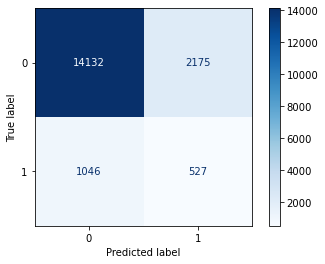

In [202]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='Blues')

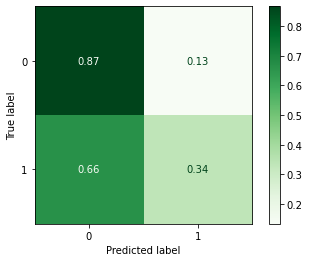

In [203]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, normalize='true', cmap='Greens')

In [204]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.87      0.90     16307
           1       0.20      0.34      0.25      1573

    accuracy                           0.82     17880
   macro avg       0.56      0.60      0.57     17880
weighted avg       0.87      0.82      0.84     17880



F1-optimization resulted in an accuracy score of 82%, yet with a recall score of 34% which is unsatisfactory.

b) F2-optimizing threshold

In [205]:
# calculate probability estimates for class 1
y_prob = clf_calibrated.predict_proba(X_test)
y_prob_1 = y_prob[:,1]

#calculate predictions using custom discrimination threshold
y_pred = (y_prob_1 >= best_thresh_f2).astype(int)

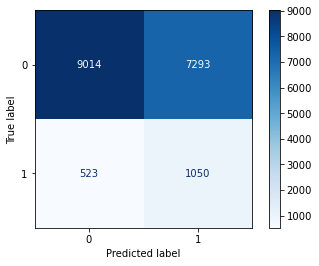

In [206]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='Blues')

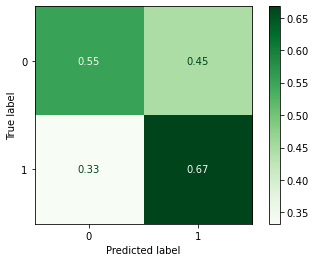

In [207]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, normalize='true', cmap='Greens')

In [208]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.55      0.70     16307
           1       0.13      0.67      0.21      1573

    accuracy                           0.56     17880
   macro avg       0.54      0.61      0.45     17880
weighted avg       0.87      0.56      0.65     17880



While F2-optimization has improved the recall score (67%), accuracy has been reduced to 56%. This time predicting majority classes is more difficult for the model. 

### 3.5.6 Gradient Boosting on Resampled Data
[Back to top](#top)

Another approach to handling the imbalance in our dataset has been to upsample, downsample and use SMOTE. We simply look at the classification report for these approaches to check whether they have better chances than the original dataset we used in the steps above.

In [209]:
clf_rus = clf
clf.fit(X_train_rus, y_train_rus)

print(classification_report(y_test, clf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.94      0.64      0.76     16307
           1       0.13      0.57      0.22      1573

    accuracy                           0.64     17880
   macro avg       0.54      0.61      0.49     17880
weighted avg       0.87      0.64      0.72     17880



In [211]:
clf_ros = clf
clf.fit(X_train_ros, y_train_ros)

print(classification_report(y_test, clf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.94      0.66      0.77     16307
           1       0.14      0.56      0.22      1573

    accuracy                           0.65     17880
   macro avg       0.54      0.61      0.50     17880
weighted avg       0.87      0.65      0.73     17880



In [212]:
clf_smote = clf

clf.fit(X_train_smote, y_train_smote)

print(classification_report(y_test, clf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.92      0.95      0.93     16307
           1       0.15      0.09      0.11      1573

    accuracy                           0.88     17880
   macro avg       0.53      0.52      0.52     17880
weighted avg       0.85      0.88      0.86     17880



#### Conclusion
The results acquired from upsampling and downsampling are quite similar to that of our original dataset. However, SMOTE does not seem to be capable of creating better odds for our Gradient Boosting models to perform.

### 3.5.7 Permutation Importance
[Back to top](#top)

Through permutation importance we aim to find out what features are most important for the model when making predictions.

In [160]:
# Finding the most important features for the model.
result = permutation_importance(clf, X_test, y_test, n_repeats=10,random_state=0)

In [161]:
df_best_feature = pd.DataFrame({'features':X_test.columns,'mean_importance':result.importances_mean})

In [162]:
df_best_feature.sort_values(ascending=False, by='mean_importance')

,features,mean_importance
7,number_inpatient,0.000610
28,discharge_disposition_id_Discharged/transferre...,0.000280
1,time_in_hospital,0.000240
45,admission_source_id_ Emergency Room,0.000224
34,discharge_disposition_id_Discharged/transferre...,0.000196
...,...,...
220,insulin_No,-0.000011
20,admission_type_id_Urgent,-0.000022
152,diag_2_diseases of the nervous system and sens...,-0.000050
169,diag_3_diseases of the respiratory system,-0.000056


According to the table above representing permutation importance, `number_inpatients` is the most important feature for the Gradient Boosting model's predictions.

### 3.5.8 Conclusion
[Back to top](#top)

- The GradientBoosting model did not outperform the other models
The imbalanced dataset has once again come in the way of building an effective model. Improving one metric (e.g. Recall) bears consequences on the other metric (e.g. accuracy). Given that the Gradient Boosting model has not managed to reach satisfactory levels of Recall and Precision scores, we cannot anticipate it to be used in a real-life scenario in a hospital. 